## imports

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot  import MultipleLocator
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.signal import butter, sosfilt
from gua_enums import SensorEnum,SamplingRateEnum,InterpolModesEnum
from gua_functions import *

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


## Load the dataset

In [3]:
""" def _CropAndPadArrayFront(arr, max_length,col, padding='zero'):
    if len(arr) > max_length:
        arr = arr[-max_length:]
        if(col=='timestamp'):
            return arr-arr[0]
        else:
            return arr
            
    else:
        pad_length = max_length - len(arr)
        if padding == 'linear':
            dt = np.mean(np.diff(arr))
            #print(dt)
            padded_arr = np.concatenate((np.linspace(0., arr[0]+dt*pad_length,num=pad_length, endpoint=False, retstep=False), arr+dt*pad_length))
            return padded_arr
        elif padding =='edge':
            padding_value = arr[0]
        elif padding =='zero':
            padding_value = np.zeros((arr[0].shape))
        else:
            padding_value = np.empty_like(arr[0])

        padded_arr = np.concatenate((np.repeat([padding_value], [pad_length], axis=0), arr))
        return padded_arr

# arr= np.array([0,0.49,1,1.51,2])
# print(arr.shape)
# _CropAndPadArrayFront(arr, 8,'linear')

def cropAndPadDfFront(df:pd.DataFrame, length = 4000, padding = ['linear','zero'], cols=['timestamp','sensordata']):
    assert len(np.asarray(padding)) == np.asarray(len(cols))
    for idx, col in enumerate(cols):
        print(col, ' : ',padding[idx])
        df[col] = df[col].apply(lambda x: _CropAndPadArrayFront(x, length,col=col, padding= padding[idx]))
    return df

def plotOldAndNew(oldD, newD, mtitle=""):
    plt.figure()
    plt.suptitle(mtitle)
    for i in range(0,5):
        plt.subplot(2,5,i+1)

        VALS = newD[i]
        plt.plot(VALS[:,0])
        plt.plot(VALS[:,1])
        plt.plot(VALS[:,2])
    for i in range(0,5):
        plt.subplot(2,5,5+i+1)
        VALS = oldD[i]
        plt.plot(VALS[:,0])
        plt.plot(VALS[:,1])
        plt.plot(VALS[:,2])
        #print(TS[-1])
    plt.subplot(2, 5, 1)
    plt.title("Recreated data")
    plt.subplot(2, 5, 6)
    plt.title("Original data")
    plt.gcf().set_size_inches(10,4)
    plt.tight_layout()
    plt.show() 

def plotPca(x_train,x_test, y_train, y_test, encoder, latent_dim, MLength):
    from sklearn.decomposition import PCA
    from matplotlib.colors import ListedColormap
    from mpl_toolkits.mplot3d import Axes3D
    #colors:
    colors = ['black', 'red']  # train set
    unique_class_ids = np.unique(y_train)
    color_map = ListedColormap([colors[i % len(colors)] for i in range(len(unique_class_ids))])
    cs = color_map(y_train)
    colors2 = ['blue', 'green' ]  # test set
    color_map2 = ListedColormap([colors2[i % len(colors2)] for i in range(len(unique_class_ids))])
    cs2 = color_map2(y_test)
    
    original_data = x_train
    encoded_data = encoder.encoder(original_data).numpy()
    decoded_data = encoder.decoder(encoded_data).numpy()

    original_test_data = x_test
    encoded_test_data = encoder.encoder(original_test_data).numpy()
    decoded_test_data = encoder.decoder(encoded_test_data).numpy()


# Create a PCA instance: pca
    pca_o = PCA(n_components=3)
    pca_e = PCA(n_components=3)
    pca_d = PCA(n_components=3)

# Fit and transform the data array
    pca_original = pca_o.fit_transform(original_data.reshape(-1,MLength*3))
    pca_original_test = pca_o.transform(original_test_data.reshape(-1,MLength*3))

    pca_encoded = pca_e.fit_transform(encoded_data.reshape(-1,latent_dim))
    pca_encoded_test = pca_e.transform(encoded_test_data.reshape(-1,latent_dim))

    pca_decoded = pca_d.fit_transform(decoded_data.reshape(-1,MLength*3))
    pca_decoded_test = pca_d.transform(decoded_test_data.reshape(-1,MLength*3))

# Create a 3D plot
    fig = plt.figure(figsize=(10,6))
    fig.suptitle('PCA of autoencoder')
    ax = fig.add_subplot(131, projection='3d')
    ax.scatter(pca_original[:,0], pca_original[:,1], pca_original[:,2], alpha=0.5, c=cs, marker='x', label='original')
    ax.scatter(pca_original_test[:,0], pca_original_test[:,1], pca_original_test[:,2], alpha=0.5, c=cs2, marker='x', label='original test')
    ax.legend(loc='upper right')
    ax = fig.add_subplot(132, projection='3d')
    ax.scatter(pca_encoded[:,0], pca_encoded[:,1], pca_encoded[:,2], alpha=0.5, c=cs, marker='.', label='encoded')
    ax.scatter(pca_encoded_test[:,0], pca_encoded_test[:,1], pca_encoded_test[:,2], alpha=0.5, c=cs2, marker='.', label='encoded test')
    ax.legend(loc='upper right')
    ax = fig.add_subplot(133, projection='3d')
    ax.scatter(pca_decoded[:,0], pca_decoded[:,1], pca_decoded[:,2], alpha=0.5, c=cs, marker='o', label='decoded')
    ax.scatter(pca_decoded_test[:,0], pca_decoded_test[:,1], pca_decoded_test[:,2], alpha=0.5, c=cs2, marker='o', label='decoded test')
    ax.legend(loc='upper right')
    plt.show()

 """

' def _CropAndPadArrayFront(arr, max_length,col, padding=\'zero\'):\n    if len(arr) > max_length:\n        arr = arr[-max_length:]\n        if(col==\'timestamp\'):\n            return arr-arr[0]\n        else:\n            return arr\n            \n    else:\n        pad_length = max_length - len(arr)\n        if padding == \'linear\':\n            dt = np.mean(np.diff(arr))\n            #print(dt)\n            padded_arr = np.concatenate((np.linspace(0., arr[0]+dt*pad_length,num=pad_length, endpoint=False, retstep=False), arr+dt*pad_length))\n            return padded_arr\n        elif padding ==\'edge\':\n            padding_value = arr[0]\n        elif padding ==\'zero\':\n            padding_value = np.zeros((arr[0].shape))\n        else:\n            padding_value = np.empty_like(arr[0])\n\n        padded_arr = np.concatenate((np.repeat([padding_value], [pad_length], axis=0), arr))\n        return padded_arr\n\n# arr= np.array([0,0.49,1,1.51,2])\n# print(arr.shape)\n# _CropAndPad

In [4]:
df = pd.read_pickle('combined.pkl')
print(df['uid'].value_counts())

uid
0412     1670
0002     1192
90006     336
90002     302
90005     286
90004     239
90003     232
90001     150
90007     122
90010      77
90009      30
90008      23
Name: count, dtype: int64


In [5]:
df2 = df[df['stype']==SensorEnum.ACC]
df2 = df2[df2['timeoutFlag']==False]
df2 = df2[df2['uid']!='0412']
df2 = df2[df2['uid']!='90009']
df2 = df2[df2['uid']!='90008']
df2 = df2[df2['samplerate']==SamplingRateEnum.FASTEST]
df2 = df2[df2['timestamp'].apply(lambda x: len(x) > 1000)]
df2['uid'].value_counts()

uid
0002     142
90006     34
90004     32
90002     29
90005     27
90001     20
90003     19
90007     15
90010     11
Name: count, dtype: int64

In [6]:
avg_diff = np.mean(np.diff(df2['lin_timestamp'].iloc[0]))
average_sample_rate = 1/(avg_diff/1000000000)
print(average_sample_rate)


418.51188971934005


In [7]:
import numpy as np
import pywt

# Apply a sliding window weighted moving average
window_size = 50
weights = np.ones(window_size) / window_size

df2['lin_sensordata'] = df2['lin_sensordata'].apply(lambda x: np.array([np.convolve(xi, weights, mode='valid') for xi in x.T]).T)


#threshold = 7  

#df2['lin_sensordata'] = df2['lin_sensordata'].apply(lambda x: np.array([pywt.threshold(pywt.wavedec(xi, 'coif5'), threshold, mode='hard') for xi in x.T]).T)

In [2]:
MLength = 1000

In [ ]:
df3=df2.reset_index(drop=True)
dfx = cropAndPadDfFront(df3,length = MLength, padding = ['linear','edge'], cols=['lin_timestamp','lin_sensordata'])
x_all = dfx['lin_sensordata']
y_all = dfx['uid']
TARGET = "0002"
x_mine = dfx['lin_sensordata'][dfx['uid']==TARGET]
y_mine = dfx['uid'][dfx['uid']==TARGET]
x_other= dfx['lin_sensordata'][dfx['uid']!=TARGET]
y_other= dfx['uid'][dfx['uid']!=TARGET]

all_data_array = np.array(x_all.to_list())
all_data_tensor = tf.convert_to_tensor(all_data_array, dtype=tf.float32)

target_data_array = np.array(x_mine.to_list())
target_data_tensor = tf.convert_to_tensor(target_data_array, dtype=tf.float32)

not_aligned_data_array = np.array(x_other.to_list())
other_data_tensor = tf.convert_to_tensor(other_data_array, dtype=tf.float32)

print("all data shape:",all_data_tensor.shape,"\ntarget data shape: ", target_data_tensor.shape, "\nother data shape: ", other_data_tensor.shape)


lin_timestamp  :  linear
lin_sensordata  :  edge
all data shape: (329, 1000, 3) 
my data shape:  (142, 1000, 3) 
other data shape:  (187, 1000, 3)


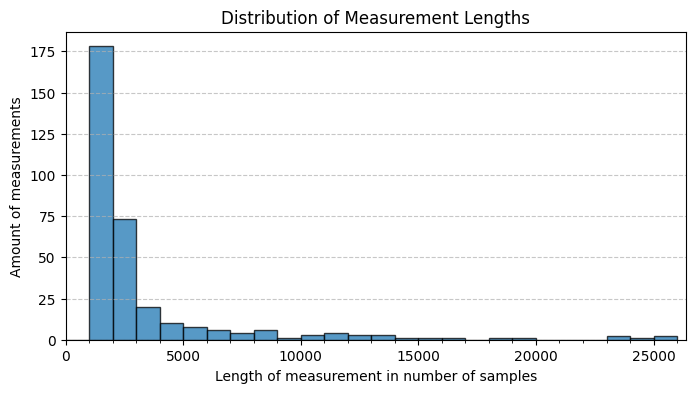

[(1622, 3) (1278, 3) (1361, 3) (1365, 3) (1595, 3) (1506, 3) (2048, 3)
 (2259, 3) (1404, 3) (1406, 3) (1482, 3) (1425, 3) (1597, 3) (1641, 3)
 (1336, 3) (1525, 3) (1400, 3) (1399, 3) (1575, 3) (4474, 3) (1475, 3)
 (1769, 3) (1569, 3) (1495, 3) (1656, 3) (1347, 3) (2118, 3) (1740, 3)
 (1592, 3) (1709, 3) (25366, 3) (1682, 3) (1420, 3) (1584, 3) (2014, 3)
 (2318, 3) (1463, 3) (3379, 3) (1797, 3) (1767, 3) (1654, 3) (1958, 3)
 (1470, 3) (1653, 3) (1809, 3) (3295, 3) (1624, 3) (1730, 3) (1472, 3)
 (1598, 3) (2673, 3) (1408, 3) (1828, 3) (1239, 3) (1705, 3) (2565, 3)
 (2787, 3) (1877, 3) (1513, 3) (1176, 3) (1697, 3) (1830, 3) (5001, 3)
 (2393, 3) (1786, 3) (1684, 3) (1897, 3) (2662, 3) (1844, 3) (1840, 3)
 (1846, 3) (1738, 3) (2335, 3) (2582, 3) (1900, 3) (2451, 3) (2137, 3)
 (2396, 3) (2379, 3) (3244, 3) (2840, 3) (1621, 3) (2295, 3) (1422, 3)
 (1505, 3) (1745, 3) (1251, 3) (1576, 3) (1264, 3) (1169, 3) (2303, 3)
 (2144, 3) (1386, 3) (1411, 3) (1387, 3) (1716, 3) (1345, 3) (1717, 3)
 (146

In [10]:
lens = df2['timestamp'].apply(len)
bins = np.arange(0, lens.max() + 1000, 1000)
length_counts = pd.cut(lens, bins=bins).value_counts().sort_index()
plt.figure(figsize=(8, 4))
plt.hist(lens, bins=bins, edgecolor='k', alpha=0.75)
plt.xlabel('Length of measurement in number of samples')
plt.ylabel('Amount of measurements')
plt.xlim(0,lens.max()+1000)
plt.title('Distribution of Measurement Lengths')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().xaxis.set_major_locator(MultipleLocator(5000))
plt.gca().xaxis.set_major_formatter('{x:.0f}')
plt.gca().xaxis.set_minor_locator(MultipleLocator(1000))
plt.show() 
print(df2['sensordata'].apply(lambda x: (x.shape)).unique())


#max =37600
#df3[x['timestamp'].apply(lambda item: len(item)==37600)]

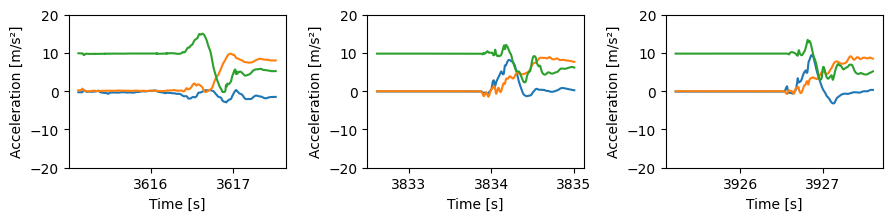

In [11]:
plt.figure(figsize=(15,10))
for i in range(0,3):
    plt.subplot(2,5,i+1)
    
    maxitem=dfx.iloc[i]
    TS = maxitem['lin_timestamp']
    VALS = maxitem['lin_sensordata']
    plt.plot(TS*pow(10,-9),VALS[:,0])
    plt.plot(TS*pow(10,-9),VALS[:,1])
    plt.plot(TS*pow(10,-9),VALS[:,2])
    plt.ylim(-20,20)
    plt.ylabel('Acceleration [m/s²]')
    plt.xlabel('Time [s]')

    #print(TS[-1])
plt.gcf().set_size_inches(15,4)
plt.tight_layout()

#### Train test split

In [97]:
file_path = './combined_all_interpol_synced_4sec_800samples_prot4.pkl'

dataFrame = pd.read_pickle(file_path)


print(dataFrame.columns)
y = np.array(dataFrame['uid'])
x = None
for col in dataFrame.columns:
    if 'sensordata' in col:
        if x is None:
            x = np.array(dataFrame[col].apply(lambda x: np.array(x)).to_list())
            #print(x_data.shape)
        else:
            x_data = np.array(dataFrame[col].apply(lambda x: np.array(x)).to_list())
            #print(x_data.shape)
            x = np.append(x, x_data , axis=2)
dur = np.array(dataFrame['duration'])
print("Dataset shapes: ")
print(x.shape)
print(dur.shape)
print(y.shape)

print("number of samples per class: ")
print(np.unique(y, return_counts=True))

def split_features_and_adjust_labels(x, y, window_size=100, overlap=0.4):
    num_samples = x.shape[0]
    num_timesteps = x.shape[1]
    num_features = x.shape[2]

    step_size = int(window_size * (1 - overlap))
    num_segments = int((num_timesteps - window_size) / step_size) + 1

    split_x = np.zeros((num_samples * num_segments, window_size, num_features))
    adjusted_y = np.repeat(y, num_segments)

    segment_index = 0
    for sample_index in range(num_samples):
        for i in range(0, num_timesteps - window_size + 1, step_size):
          split_x[segment_index] = x[sample_index, i : i + window_size, :]
          segment_index += 1

    return split_x, adjusted_y, num_segments

def get_aligned_and_rest(split_x, adjusted_y,num_segments):
    x_aligned = []
    y_aligned = []
    x_not_aligned = []
    y_not_aligned = []

    for i in range(len(adjusted_y)):
        if i % num_segments == 0:
            x_aligned.append(split_x[i])
            y_aligned.append(adjusted_y[i])
        else:
            x_not_aligned.append(split_x[i])
            y_not_aligned.append(adjusted_y[i])
    return np.array(x_aligned), np.array(y_aligned), np.array(x_not_aligned), np.array(y_not_aligned)


split_x, adjusted_y,num_segments  = split_features_and_adjust_labels(x,y,window_size=100,overlap=0)
print(split_x.shape, adjusted_y.shape)
x_aligned, y_aligned, x_not_aligned, y_not_aligned = get_aligned_and_rest(split_x,adjusted_y, num_segments)


y_aligned = y_aligned.astype(str)
y_not_aligned = y_not_aligned.astype(str)
x = x_aligned
y = y_aligned


class_label_encoder = LabelEncoder()


y = class_label_encoder.fit_transform(y)
y_not_aligned = class_label_encoder.transform(y_not_aligned)
n_classes = class_label_encoder.classes_.shape[0]



"""

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

x_other_scaled = scaler.transform(x_other.reshape(-1, x_other.shape[-1])).reshape(x_other.shape)
x_other = x_other_scaled

print(x_other.shape, y_other.shape)
"""


Index(['uid', 'sensordata.ACC', 'sensordata.GYR', 'sensordata.GRV',
       'sensordata.MAG', 'sensordata.ROT', 'duration'],
      dtype='object', name='stype')
Dataset shapes: 
(332, 800, 17)
(332,)
(332,)
number of samples per class: 
(array(['0112', '0113', '0114', '90001', '90002', '90003', '90004',
       '90005', '90006', '90007', '90010'], dtype=object), array([52, 51, 51, 20, 29, 17, 28, 24, 34, 15, 11]))
(2656, 100, 17) (2656,)


'\n\nx_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)\nprint(x_train.shape, x_test.shape, y_train.shape, y_test.shape)\nx_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)\nx_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)\nprint(x_train.shape, x_test.shape, y_train.shape, y_test.shape)\n\nx_other_scaled = scaler.transform(x_other.reshape(-1, x_other.shape[-1])).reshape(x_other.shape)\nx_other = x_other_scaled\n\nprint(x_other.shape, y_other.shape)\n'

In [11]:
print(class_label_encoder.transform(class_label_encoder.classes_))

[ 0  1  2  3  4  5  6  7  8  9 10]


In [61]:
all_scaler = StandardScaler()
target_scaler = StandardScaler()
other_scaler = StandardScaler()

target_label = [0]
negative_label = [3,4,5,5,6,7,8,9,10]
x_target = x[np.isin(y, target_label)]
y_target = y[np.isin(y, target_label)]
x_other = x[np.isin(y, negative_label)]
y_other = y[np.isin(y, negative_label)]




all_x_train, all_x_test, all_y_train, all_y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=42)
all_x_train = all_scaler.fit_transform(all_x_train.reshape(-1, all_x_train.shape[-1])).reshape(all_x_train.shape)
all_x_test = all_scaler.transform(all_x_test.reshape(-1, all_x_test.shape[-1])).reshape(all_x_test.shape)

target_x_train, target_x_test, target_y_train, target_y_test = train_test_split(x_target,
                                                    y_target,
                                                    test_size=0.33,
                                                    random_state=42)
target_x_train = target_scaler.fit_transform(target_x_train.reshape(-1, target_x_train.shape[-1])).reshape(target_x_train.shape)
target_x_test = target_scaler.transform(target_x_test.reshape(-1, target_x_test.shape[-1])).reshape(target_x_test.shape)

other_x_train, other_x_test, other_y_train, other_y_test = train_test_split(x_other,
                                                    y_other,
                                                    test_size=0.33,
                                                    random_state=42)
other_x_train = other_scaler.fit_transform(other_x_train.reshape(-1, other_x_train.shape[-1])).reshape(other_x_train.shape)
other_x_test = other_scaler.transform(other_x_test.reshape(-1, other_x_test.shape[-1])).reshape(other_x_test.shape)



## Models:

### Autoencoder - Flattened, Dense layer - 1500,3 - 8 - 1500,3
#### Trained with target_data

In [62]:
target_x_train.shape

(34, 100, 17)

In [39]:
import keras
import os
import json

In [63]:
MPATH = './new_autoencoder_model_target'+""
input_shape = x_target.shape[1:]

class SaveModelCheckpoint(keras.callbacks.Callback):
    def __init__(self, filepath, interval=10):
        super(SaveModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.interval = interval
    def on_train_end(self, logs=None):
        filepath = self.filepath.format(epoch="0")
        # Create the directory if it doesn't exist
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        print(f"Saving history to {filepath}")
        with open(self.filepath+'.json', 'a') as f:
            json.dump(self.model.history.history, f, indent=4)

# Create an instance of the custom callback
save_checkpoint_callback = SaveModelCheckpoint(MPATH +'_{epoch}', interval=10)

callbacks = [keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True), save_checkpoint_callback]

In [92]:
from keras import losses,Model
from keras.models import load_model
latent_dim = 64
MLength = 100
dims = 17


MPATH = './new_autoencoder_model_target_0'
input_shape = all_x_train.shape[1:]

class SaveModelCheckpoint(keras.callbacks.Callback):
    def __init__(self, filepath, interval=10):
        super(SaveModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.interval = interval

    def on_train_end(self, logs=None):
        filepath = self.filepath
        # Create the directory if it doesn't exist
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        print(f"Saving history to {filepath}")
        with open(self.filepath+'.json', 'a') as f:
            json.dump(self.model.history.history, f, indent=4)

# Create an instance of the custom callback
save_checkpoint_callback = SaveModelCheckpoint(MPATH, interval=10)

callbacks = [keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True), save_checkpoint_callback]

@keras.saving.register_keras_serializable()
class Autoencoder(Model):
  def __init__(self, latent_dim, mLength, dims, **kwargs):
      super(Autoencoder, self).__init__(**kwargs)
      self.latent_dim = latent_dim
      self.mLength = mLength
      self.dims = dims
      self.encoder = tf.keras.Sequential([
          layers.Flatten(),
          layers.Dense(self.latent_dim, activation='relu'),
      ])
      self.decoder = tf.keras.Sequential([
          layers.Dense(self.mLength * self.dims, activation='linear'),
          layers.Reshape((self.mLength, self.dims)),
      ])

  def call(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

  def get_config(self):
      # Include all parameters needed for re-creation
      config = super(Autoencoder, self).get_config()
      config.update({
          "latent_dim": self.latent_dim,
          "mLength": self.mLength,
          "dims": self.dims,
      })
      return config

  @classmethod
  def from_config(cls, config):
      # Return an instance of the model
      return cls(**config)




autoencoder = Autoencoder(latent_dim,MLength,dims)
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                    loss=losses.MeanSquaredError())
autoencoder.summary()

Model: "autoencoder_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_22 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_23 (Sequential)      │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [94]:
with tf.device('/GPU:0'):
    autoencoder.fit(
    all_x_train,
    all_x_train,
    validation_split=0.2,
    epochs=80,
    batch_size=32,
    callbacks=callbacks,
    )

Epoch 1/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2657 - val_loss: 0.7662
Epoch 2/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0722 - val_loss: 0.7566
Epoch 3/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1685 - val_loss: 0.7490
Epoch 4/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9867 - val_loss: 0.7429
Epoch 5/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0248 - val_loss: 0.7375
Epoch 6/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9982 - val_loss: 0.7325
Epoch 7/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0452 - val_loss: 0.7274
Epoch 8/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9495 - val_loss: 0.7215
Epoch 9/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0083 - val_loss: 0.7148
Epoch 10/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8885 - val_loss: 0.7077
Epoch 11/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0145 - val_loss: 0.6994
Epoch 12/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0651 - val_loss: 0.6900
Epoch 13/80
6

In [96]:
from sklearn import svm
from sklearn.metrics import classification_report
encoded_train = autoencoder.encoder(all_x_train).numpy()
encoded_test = autoencoder.encoder(all_x_test).numpy()
svm = svm.SVC()
svm.fit(encoded_train, all_y_train)
print(classification_report(all_y_test, svm.predict(encoded_test)))

              precision    recall  f1-score   support

           0       0.62      0.89      0.73        18
           1       0.67      0.42      0.52        19
           2       0.65      0.83      0.73        18
           3       0.30      1.00      0.46         3
           4       0.73      0.67      0.70        12
           5       1.00      0.67      0.80         3
           6       0.88      0.64      0.74        11
           7       0.83      0.71      0.77         7
           8       0.71      0.56      0.62         9
           9       1.00      0.83      0.91         6
          10       0.00      0.00      0.00         4

    accuracy                           0.67       110
   macro avg       0.67      0.66      0.63       110
weighted avg       0.69      0.67      0.66       110



c:\GUA\gh_repo\GUA\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\GUA\gh_repo\GUA\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\GUA\gh_repo\GUA\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/stepWARNING:tensorflow:5 out of the last 20 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002CD040B7600> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


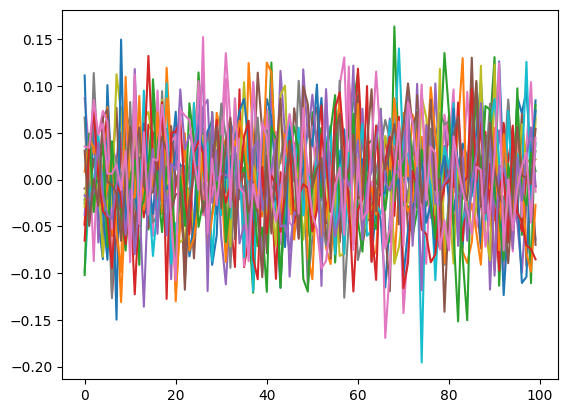

In [ ]:

predicted = autoencoder.predict(all_x_test)
plt.plot(predicted[4])

In [15]:
""" original_data = all_x_test
encoded_data = autoencoder.encoder(original_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy() """

' original_data = all_x_test\nencoded_data = autoencoder.encoder(original_data).numpy()\ndecoded_data = autoencoder.decoder(encoded_data).numpy() '

In [16]:
""" 
# Create a PCA instance: pca
pca = PCA(n_components=2)


# Fit and transform the data array
pca_original = pca.fit_transform(original_data.reshape(-1,MLength*3))
pca_encoded = pca.fit_transform(encoded_data.reshape(-1,latent_dim))
pca_decoded = pca.fit_transform(decoded_data.reshape(-1,MLength*3))

cs = all_y_train
# Plotting the results
plt.figure(figsize=(8,6))
plt.scatter(pca_original[:,0], pca_original[:,1],alpha=0.5, c=cs,marker='x', label='original')
plt.scatter(pca_encoded[:,0], pca_encoded[:,1],alpha=0.5, c=cs,marker='.', label='encoded')
plt.scatter(pca_decoded[:,0], pca_decoded[:,1],alpha=0.5, c=cs,marker='o', label='decoded')

plt.legend()
plt.show() """

" \n# Create a PCA instance: pca\npca = PCA(n_components=2)\n\n\n# Fit and transform the data array\npca_original = pca.fit_transform(original_data.reshape(-1,MLength*3))\npca_encoded = pca.fit_transform(encoded_data.reshape(-1,latent_dim))\npca_decoded = pca.fit_transform(decoded_data.reshape(-1,MLength*3))\n\ncs = all_y_train\n# Plotting the results\nplt.figure(figsize=(8,6))\nplt.scatter(pca_original[:,0], pca_original[:,1],alpha=0.5, c=cs,marker='x', label='original')\nplt.scatter(pca_encoded[:,0], pca_encoded[:,1],alpha=0.5, c=cs,marker='.', label='encoded')\nplt.scatter(pca_decoded[:,0], pca_decoded[:,1],alpha=0.5, c=cs,marker='o', label='decoded')\n\nplt.legend()\nplt.show() "

In [43]:
%matplotlib inline
plotPca(all_x_train,all_x_test, all_y_train, all_y_test, autoencoder, latent_dim, MLength,2)




ValueError: cannot reshape array of size 187000 into shape (300)

In [19]:
%matplotlib inline
plt.figure()
plt.close()


In [80]:
encoded_data = autoencoder.encoder(target_x_test).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()
et = autoencoder.encoder(target_x_train).numpy()
det = autoencoder.decoder(et).numpy()

In [55]:
%pip install fastdtw

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for fastdtw: filename=fastdtw-0.3.4-py3-none-any.whl size=3586 sha256=485dd2bc8864e4e4175a4cd584d11532c72407552617e0d7c1f9034d5d0708f2
  Stored in directory: c:\users\levib\appdata\local\pip\cache\wheels\5c\8a\f6\fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
Successfully built fastdtw
Note: you may need to restart the kernel to use updated packages.


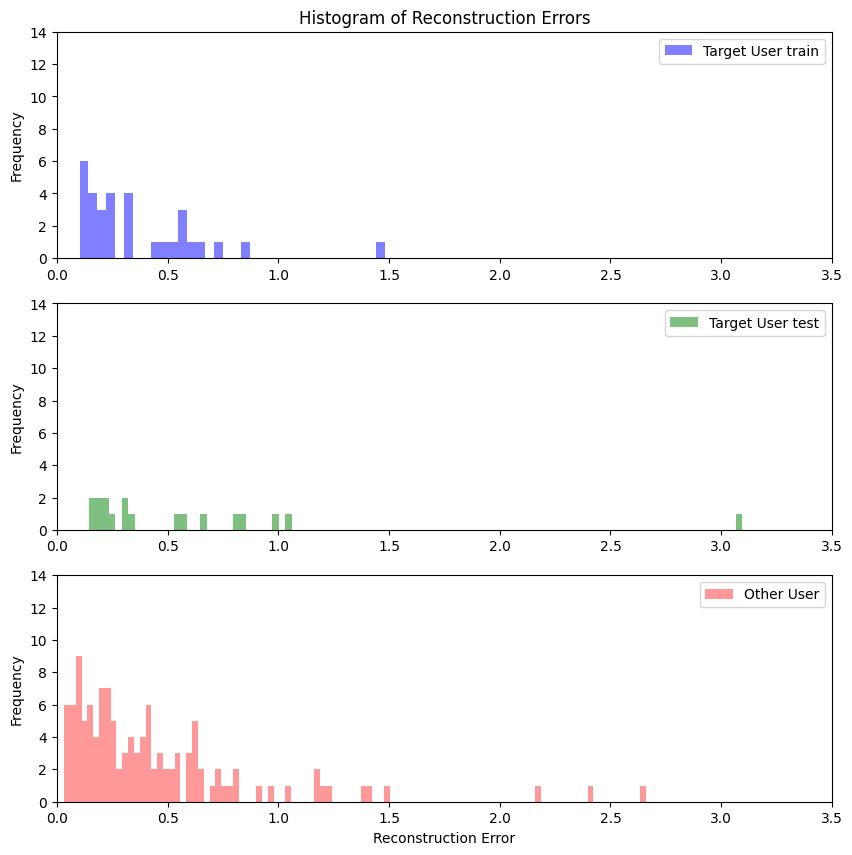

In [81]:
from fastdtw import fastdtw
# Calculate reconstruction errors for target_x_train
target_x_train_encoded = autoencoder.encoder(target_x_train).numpy()
target_x_train_decoded = autoencoder.decoder(target_x_train_encoded).numpy()
target_x_train_errors = np.mean(np.square(target_x_train - target_x_train_decoded), axis=(1, 2))
target_x_dtw = [fastdtw(target_x_train[i], target_x_train_decoded[i])[0] for i in range(len(target_x_train))]

# Calculate reconstruction errors for target_x_test
target_x_test_encoded = autoencoder.encoder(target_x_test).numpy()
target_x_test_decoded = autoencoder.decoder(target_x_test_encoded).numpy()
target_x_test_errors = np.mean(np.square(target_x_test - target_x_test_decoded), axis=(1, 2))
target_x_test_dtw = [fastdtw(target_x_test[i], target_x_test_decoded[i])[0] for i in range(len(target_x_test))]

# Calculate reconstruction errors for other_x_train
other_x_train_encoded = autoencoder.encoder(other_x_train).numpy()
other_x_train_decoded = autoencoder.decoder(other_x_train_encoded).numpy()
other_x_train_errors = np.mean(np.square(other_x_train - other_x_train_decoded), axis=(1, 2))
other_x_dtw = [fastdtw(other_x_train[i], other_x_train_decoded[i])[0] for i in range(len(other_x_train))]

# Calculate reconstruction errors for other_x_test
other_x_test_encoded = autoencoder.encoder(other_x_test).numpy()
other_x_test_decoded = autoencoder.decoder(other_x_test_encoded).numpy()
other_x_test_errors = np.mean(np.square(other_x_test - other_x_test_decoded), axis=(1, 2))
other_x_test_dtw = [fastdtw(other_x_test[i], other_x_test_decoded[i])[0] for i in range(len(other_x_test))]
                    
#calculate reconstruction errors for other_x_train_test
other_train_test = np.concatenate((other_x_train,other_x_test),axis=0)
other_train_test_encoded = autoencoder.encoder(other_train_test).numpy()
other_train_test_decoded = autoencoder.decoder(other_train_test_encoded).numpy()
other_train_test_errors = np.mean(np.square(other_train_test - other_train_test_decoded), axis=(1, 2))



# Plot histograms
plt.figure(figsize=(10, 10))
plt.subplot(3,1,1)
plt.title('Histogram of Reconstruction Errors')
plt.xlim(0,3.5)
plt.ylim(0,14)
plt.hist(target_x_train_errors, bins=100, alpha=0.5, color='blue', label='Target User train')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(3,1,2)
plt.xlim(0,3.5)
plt.ylim(0,14)
plt.hist(target_x_test_errors, bins=100, alpha=0.5, color='green', label='Target User test')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(3,1,3)
plt.xlim(0,3.5)
plt.ylim(0,14)
plt.hist(other_x_train_errors, bins=100, alpha=0.4, color='red', label='Other User')
plt.ylabel('Frequency')
plt.legend()

#plt.hist(other_train_test_errors, bins=50, alpha=0.5, label='User2 test')
#plt.hist(other_x_test_errors, bins=10, alpha=0.5, label='other_x_test')
plt.xlabel('Reconstruction Error')

plt.show()


In [ ]:
# Plot histograms
plt.figure(figsize=(10, 10))
plt.subplot(3,1,1)
plt.title('Histogram of Reconstruction Errors with DTW')

plt.hist(target_x_dtw, bins=100, alpha=0.5, color='blue', label='Target User train')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(3,1,2)

plt.hist(target_x_test_dtw, bins=100, alpha=0.5, color='green', label='Target User test')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(3,1,3)

plt.hist(other_x_dtw, bins=100, alpha=0.4, color='red', label='Other User')
plt.ylabel('Frequency')
plt.legend()
plt.xlabel('DTW reconstruction Error')

plt.show()



NameError: name 'plt' is not defined

In [83]:
threshold = np.mean(target_x_train_errors) + np.std(target_x_train_errors)
print("Threshold: ", threshold)

Threshold:  1.473210704663949


In [ ]:
predictions = (target_x_test_errors > threshold).astype(int)

In [89]:
predictions
int_pred = predictions.astype(int)-1
int_pred

array([ 0,  0,  0, -1, -1,  0, -1, -1, -1, -1,  0,  0,  0,  0, -1,  0,  0,
        0, -1, -1, -1, -1,  0,  0,  0,  0, -1, -1,  0, -1, -1, -1, -1, -1,
       -1, -1,  0, -1, -1,  0,  0, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1,
        0,  0,  0, -1,  0, -1, -1, -1,  0, -1,  0, -1,  0, -1, -1,  0,  0,
        0,  0, -1,  0, -1,  0,  0, -1, -1,  0, -1, -1, -1,  0, -1, -1,  0,
        0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0, -1,  0,  0,  0,  0, -1,
        0, -1,  0,  0, -1, -1, -1])

In [106]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
reconstructions = autoencoder(all_x_test)
err = np.mean(np.square(all_x_test - reconstructions), axis=(1, 2))

def predict(model, data, threshold):
  reconstructions = model(data)
  err = np.mean(np.square(data - reconstructions), axis=(1, 2))
  return err > threshold



# Calculate the false positive rate (FPR) and true positive rate (TPR) for different thresholds
fpr, tpr, thresholds = roc_curve(all_y_test, err, pos_label=0)

# Calculate the equal error rate (EER)
eer_threshold = thresholds[np.argmin(np.abs(fpr - (1 - tpr)))]
eer = fpr[np.argmin(np.abs(fpr - (1 - tpr)))]
print(eer_threshold, eer)
# Set the threshold to achieve equal error rate
threshold = eer_threshold
predictions = predict(autoencoder, all_x_test, threshold)
int_pred = predictions.astype(int)-1

print(classification_report(all_y_test, int_pred))

0.43429622 0.6617647058823529
              precision    recall  f1-score   support

          -1       0.46      0.35      0.40        68
           0       0.23      0.32      0.27        41

    accuracy                           0.34       109
   macro avg       0.34      0.34      0.33       109
weighted avg       0.37      0.34      0.35       109



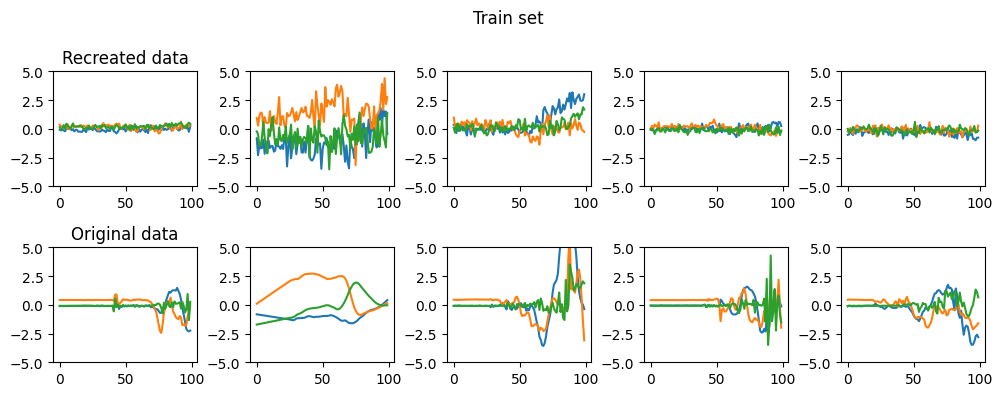

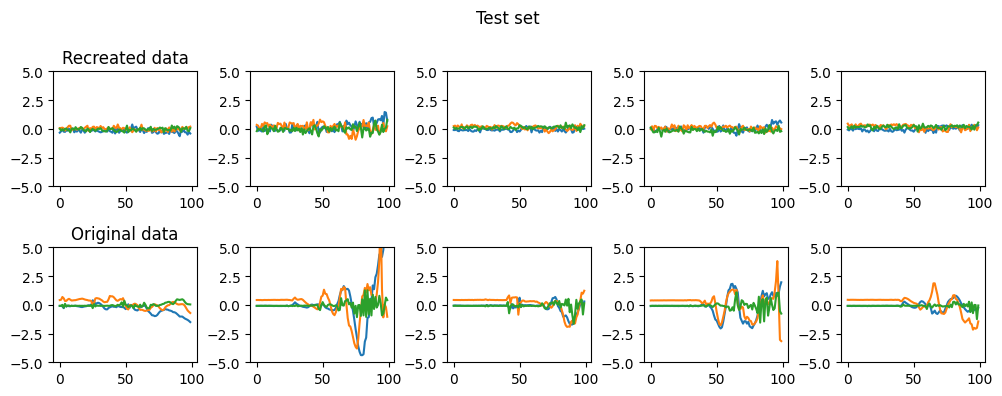

In [84]:
plotOldAndNew(target_x_train,det, "Train set", yrange=5)
print(" ")
plotOldAndNew(target_x_test, decoded_data, 'Test set', yrange=5)

In [37]:
le.transform([TARGET])

array([0])

In [44]:
import seaborn
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

all_x_train_encoded = autoencoder.encoder(all_x_train).numpy()
all_x_test_encoded = autoencoder.encoder(all_x_test).numpy()
all_y_train[all_y_train != le.transform([TARGET])] = -1
all_y_test[all_y_test != le.transform([TARGET])] = -1


svm = SVC(kernel='linear', gamma=0.1, class_weight='balanced')
tree = DecisionTreeClassifier(max_depth=4, class_weight='balanced')
svm.fit(all_x_train_encoded, all_y_train)
tree.fit(all_x_train_encoded, all_y_train)


y_pred = svm.predict(all_x_test_encoded)
cm = confusion_matrix(all_y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(classification_report(all_y_test, y_pred))
#seaborn.heatmap(cm_normalized, annot=True, fmt='.2f',cmap='RdYlGn', cbar=False)
#plt.title('Confusion Matrix')
# plt.gca().set_xticklabels(class_labels, rotation=45, ha='right')
# plt.gca().set_yticklabels(class_labels, rotation=0)
#plt.axis('equal')



              precision    recall  f1-score   support

          -1       0.91      0.74      0.81        68
           0       0.67      0.88      0.76        41

    accuracy                           0.79       109
   macro avg       0.79      0.81      0.79       109
weighted avg       0.82      0.79      0.79       109



Can seemingly follow general trends

### Complex model

In [45]:
latent_dim = 8
class ComplexModel(Model):
  def __init__(self):
    super(ComplexModel, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(latent_dim, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(MLength*3, activation='linear'),
      layers.Reshape((MLength, 3))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded



In [109]:
complexModel = ComplexModel()

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.9889 - val_loss: 1.0897
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1200 - val_loss: 1.0303
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8206 - val_loss: 0.9768
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8016 - val_loss: 0.9327
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8777 - val_loss: 0.8651
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7360 - val_loss: 0.8399
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7233 - val_loss: 0.8085
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6634 - val_loss: 0.7958
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5615 - val_loss: 0.7741
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6230 - val_loss: 0.7454
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6093 - val_loss: 0.7252
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 

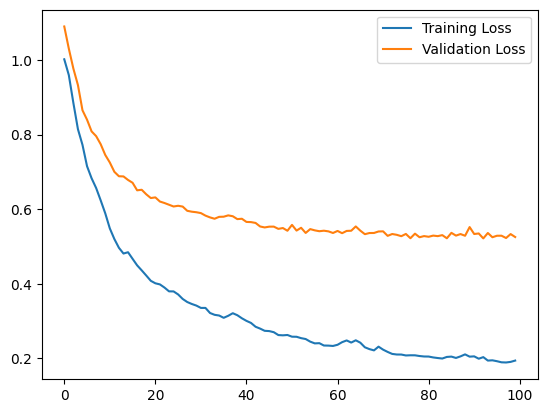

In [ ]:
complexModel.compile(optimizer='adam', loss='mse')
history = complexModel.fit(target_x_train, target_x_train,
          epochs=100,
          batch_size=8,
          validation_data=(target_x_test, target_x_test),
          shuffle=True)
plt.figure()
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

100 epochs

In [115]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean


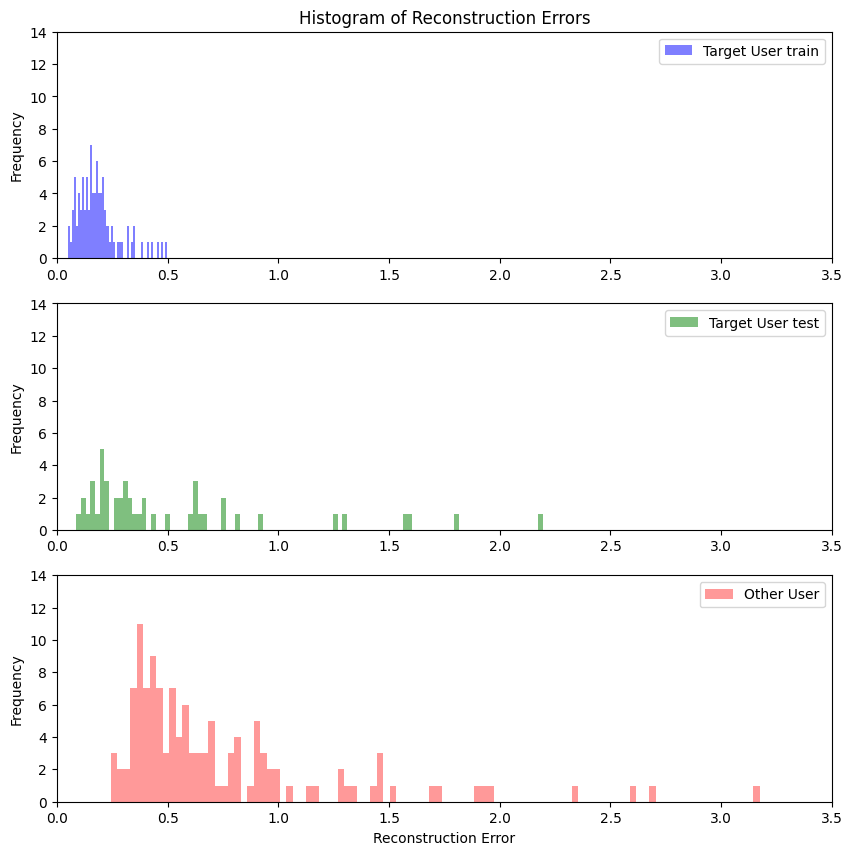

In [ ]:
# Calculate reconstruction errors for target_x_train
target_x_train_encoded = complexModel.encoder(target_x_train).numpy()
target_x_train_decoded = complexModel.decoder(target_x_train_encoded).numpy()
target_x_train_errors = np.mean(np.square(target_x_train - target_x_train_decoded), axis=(1, 2))



# Calculate reconstruction errors for target_x_test
target_x_test_encoded = complexModel.encoder(target_x_test).numpy()
target_x_test_decoded = complexModel.decoder(target_x_test_encoded).numpy()
target_x_test_errors = np.mean(np.square(target_x_test - target_x_test_decoded), axis=(1, 2))

# Calculate reconstruction errors for other_x_train
other_x_train_encoded = complexModel.encoder(other_x_train).numpy()
other_x_train_decoded = complexModel.decoder(other_x_train_encoded).numpy()
other_x_train_errors = np.mean(np.square(other_x_train - other_x_train_decoded), axis=(1, 2))


# Calculate reconstruction errors for other_x_test
other_x_test_encoded = complexModel.encoder(other_x_test).numpy()
other_x_test_decoded = complexModel.decoder(other_x_test_encoded).numpy()
other_x_test_errors = np.mean(np.square(other_x_test - other_x_test_decoded), axis=(1, 2))

#calculate reconstruction errors for other_x_train_test
other_train_test = np.concatenate((other_x_train,other_x_test),axis=0)
other_train_test_encoded = complexModel.encoder(other_train_test).numpy()
other_train_test_decoded = complexModel.decoder(other_train_test_encoded).numpy()
other_train_test_errors = np.mean(np.square(other_train_test - other_train_test_decoded), axis=(1, 2))



# Plot histograms
plt.figure(figsize=(10, 10))
plt.subplot(3,1,1)
plt.title('Histogram of Reconstruction Errors')
plt.xlim(0,3.5)
plt.ylim(0,14)
plt.hist(target_x_train_errors, bins=50, alpha=0.5, color='blue', label='Target User train')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(3,1,2)
plt.xlim(0,3.5)
plt.ylim(0,14)
plt.hist(target_x_test_errors, bins=100, alpha=0.5, color='green', label='Target User test')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(3,1,3)
plt.xlim(0,3.5)
plt.ylim(0,14)
plt.hist(other_x_train_errors, bins=100, alpha=0.4, color='red', label='Other User')
plt.ylabel('Frequency')
plt.legend()

#plt.hist(other_train_test_errors, bins=50, alpha=0.5, label='User2 test')
#plt.hist(other_x_test_errors, bins=10, alpha=0.5, label='other_x_test')
plt.xlabel('Reconstruction Error')

plt.show()


In [93]:
%run gua_functions.py

<Figure size 640x480 with 0 Axes>

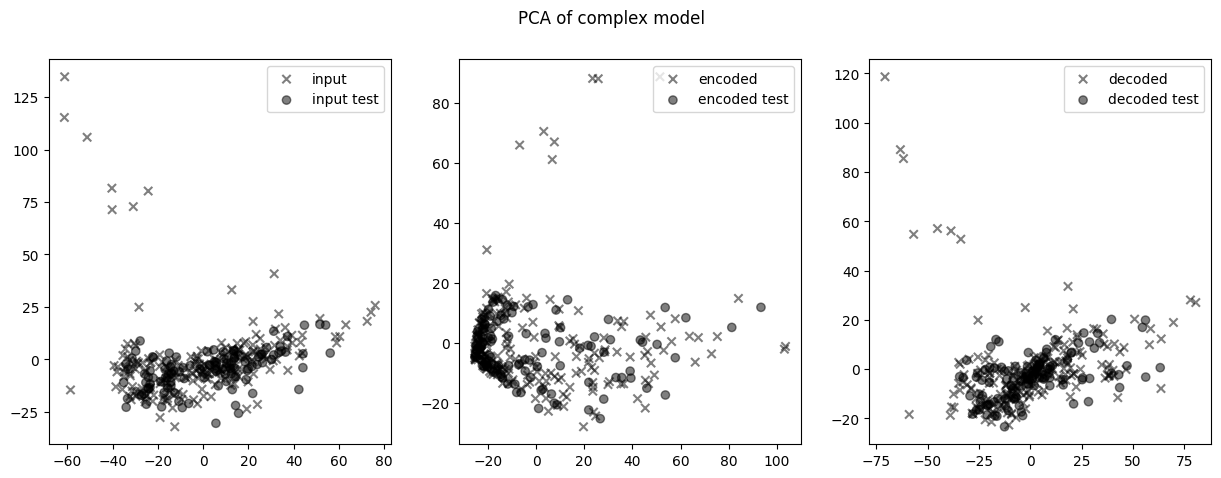

In [107]:
plotPca(all_x_train,all_x_test, all_y_train, all_y_test, complexModel, latent_dim, MLength, 2,
        title="PCA of complex model")

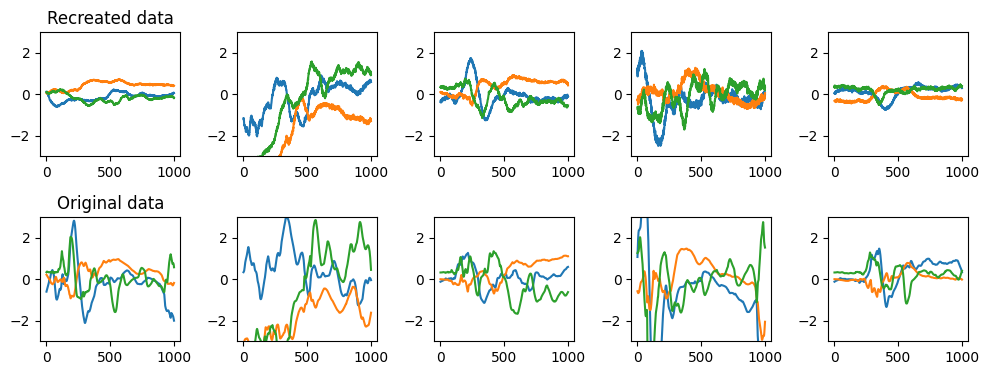

In [114]:
encoded_data = complexModel.encoder(target_x_test).numpy()
decoded_data = complexModel.decoder(encoded_data).numpy()
plotOldAndNew(target_x_test,decoded_data)

results of low epoch num  
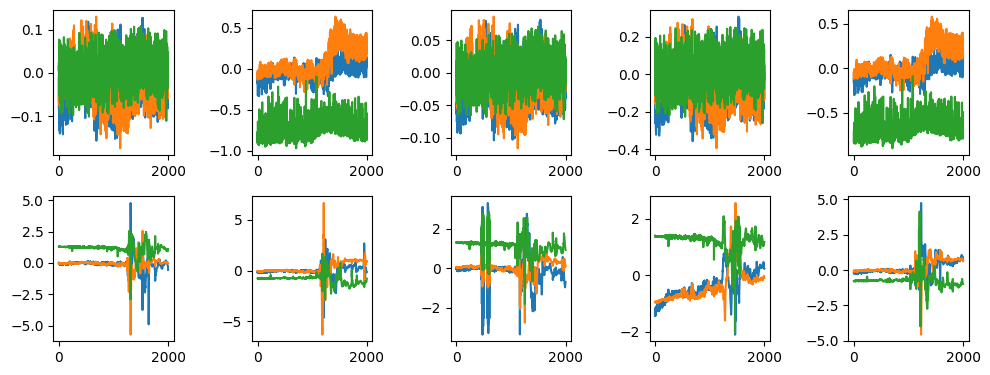

### Cut measurements to 1000 - Simple model

In [31]:
MLength=1000
df3=df2.reset_index(drop=True)

dfx1 = cropAndPadDfFront(df3,length = MLength, padding = ['linear','edge'], cols=['timestamp','sensordata'])
print(dfx1['sensordata'].apply(lambda x: (x.shape)).unique())
print(dfx1['timestamp'].apply(lambda x: (x.shape)).value_counts())
x = dfx1['sensordata']
y = dfx1['uid']
data_array = np.array(x.to_list())
data_tensor1000 = tf.convert_to_tensor(data_array, dtype=tf.float32)

x_train_1000, x_test_1000, y_train_1000, y_test_1000 = train_test_split(data_tensor1000.numpy(),
                                                    y,
                                                    test_size=0.33,
                                                    random_state=42)
mean = np.mean(x_train_1000, axis=0)
std = np.std(x_train_1000, axis=0)
x_train_1000 = (x_train_1000 - mean) / std
x_test_1000 = (x_test_1000 - mean) / std

timestamp  :  linear
sensordata  :  edge
[(1000, 3)]
timestamp
(1000,)    167
Name: count, dtype: int64


Epoch 1/500


14/14 [==============================] - 1s 11ms/step - loss: 1.0019 - val_loss: 1.2547
Epoch 2/500
14/14 [==============================] - 0s 6ms/step - loss: 0.9637 - val_loss: 1.1583
Epoch 3/500
14/14 [==============================] - 0s 6ms/step - loss: 0.8674 - val_loss: 1.0498
Epoch 4/500
14/14 [==============================] - 0s 6ms/step - loss: 0.7862 - val_loss: 0.9973
Epoch 5/500
14/14 [==============================] - 0s 7ms/step - loss: 0.7410 - val_loss: 0.9597
Epoch 6/500
14/14 [==============================] - 0s 7ms/step - loss: 0.7112 - val_loss: 0.9393
Epoch 7/500
14/14 [==============================] - 0s 7ms/step - loss: 0.6796 - val_loss: 0.9080
Epoch 8/500
14/14 [==============================] - 0s 7ms/step - loss: 0.6489 - val_loss: 0.8966
Epoch 9/500
14/14 [==============================] - 0s 7ms/step - loss: 0.6265 - val_loss: 0.8842
Epoch 10/500
14/14 [==============================] - 0s 7ms/step - loss: 0.6051 - val_loss: 0.8467
Epoch 11/500
14/14 [

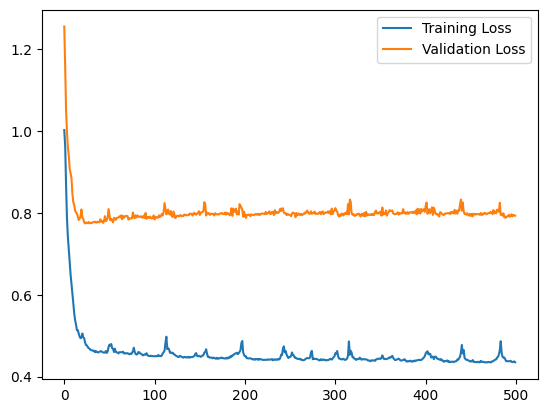

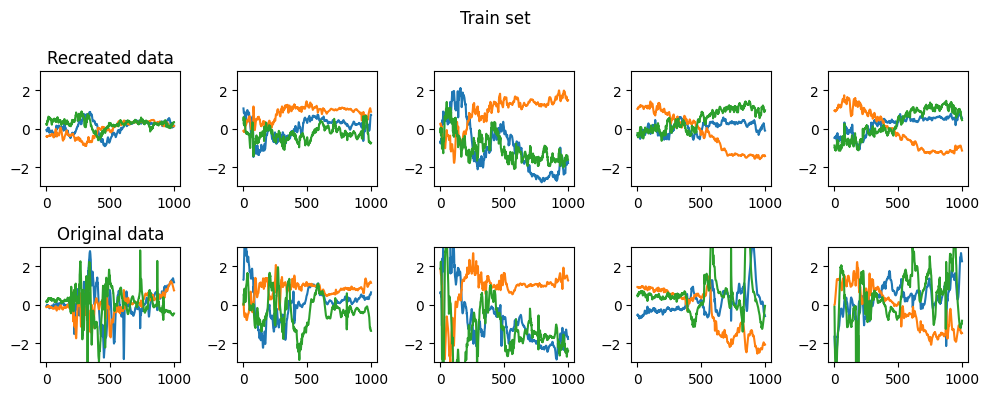

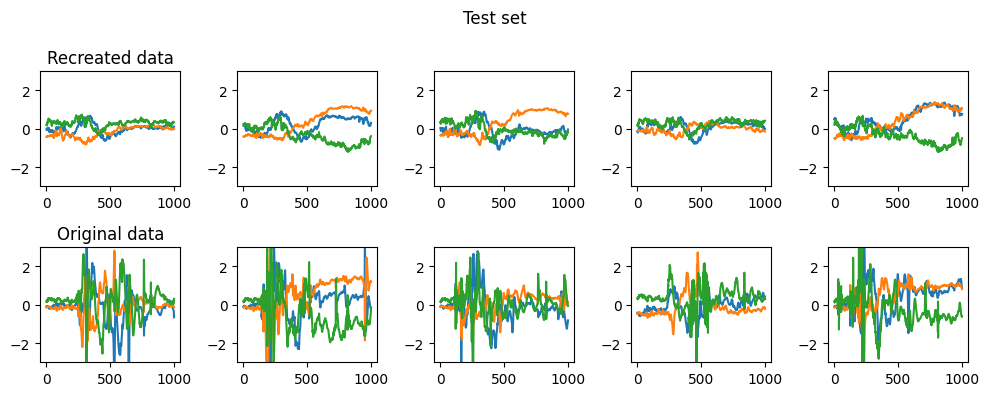

In [33]:
autoencoder1000 = Autoencoder(latent_dim,1000,3)
autoencoder1000.compile(optimizer='adam', loss=losses.MeanSquaredError())
history = autoencoder1000.fit(x_train_1000, x_train_1000,
                epochs=50,
                shuffle=True,
                batch_size=8,
                validation_data=(x_test_1000, x_test_1000))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

encoded_data = autoencoder1000.encoder(x_test_1000).numpy()
decoded_data = autoencoder1000.decoder(encoded_data).numpy()
et = autoencoder1000.encoder(x_train_1000).numpy()
det = autoencoder1000.decoder(et).numpy()
plotOldAndNew(x_train_1000,det, "Train set")
print(" ")
plotOldAndNew(x_test_1000, decoded_data, 'Test set')

50 epochs </br>
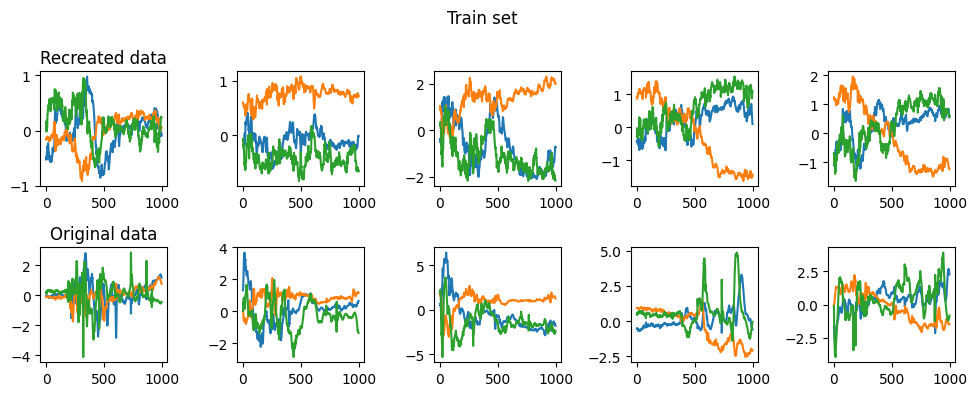
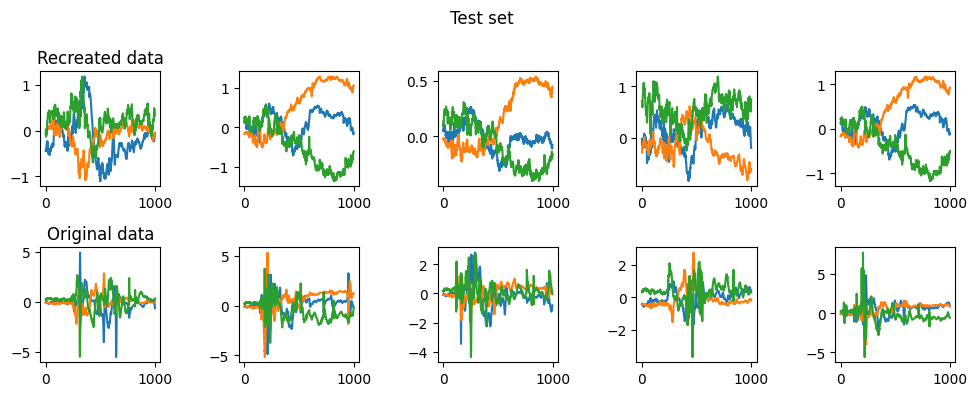

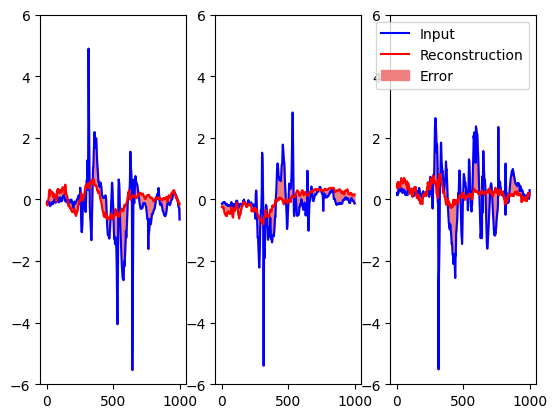

In [ ]:

for i in range(0,x_test_1000.shape[2]):
    plt.subplot(1,x_test_1000.shape[2],i+1)
    plt.plot(x_test_1000[0][:,i], 'b')
    plt.plot(decoded_data[0][:,i], 'r')
    plt.fill_between(np.arange(x_test_1000.shape[1]), decoded_data[0][:,i], x_test_1000[0][:,i], color='lightcoral')
    y_limit = max(np.abs(x_test_1000[0][:,i]).max(), np.abs(decoded_data[0][:,i]).max())
    y_limit = np.ceil(y_limit)  # Round up to ensure both positive and negative parts are visible
    plt.ylim(-y_limit, y_limit)  
plt.legend(labels=["Input", "Reconstruction", "Error"])    
plt.show()

### LSTM

In [ ]:
[sample_num,sample_len, features_num] = x_train_1000.shape

In [ ]:
class LSTMModel(Model):
  def __init__(self,latent_dim,sample_len, features_num):
    super(LSTMModel, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.LSTM(64, activation='relu', input_shape=(sample_len, features_num)),
        layers.Dense(latent_dim, activation='relu')
      ])

    self.decoder = tf.keras.Sequential([
        layers.RepeatVector(sample_len, input_shape=[latent_dim]),
        layers.LSTM(64, activation='relu', return_sequences=True),
        layers.TimeDistributed(layers.Dense(features_num))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


In [ ]:
lstm = LSTMModel(32,sample_len, features_num)
lstm.compile(optimizer='adam', loss=losses.MeanSquaredError())
history = lstm.fit(x_train_1000, x_train_1000,
                epochs=10,
                shuffle=True,
                batch_size=8,
                validation_data=(x_test_1000, x_test_1000))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

encoded_data = lstm.encoder(x_test_1000).numpy()
decoded_data = lstm.decoder(encoded_data).numpy()
et = lstm.encoder(x_train_1000).numpy()
det = lstm.decoder(et).numpy()
plotOldAndNew(x_train_1000,det, "Train set")
print(" ")
plotOldAndNew(x_test_1000, decoded_data, 'Test set')

Epoch 1/10


14/14 [==============================] - 15s 961ms/step - loss: 0.9681 - val_loss: nan
Epoch 2/10
14/14 [==============================] - 13s 958ms/step - loss: nan - val_loss: nan
Epoch 3/10
14/14 [==============================] - 13s 944ms/step - loss: nan - val_loss: nan
Epoch 4/10
14/14 [==============================] - 13s 957ms/step - loss: nan - val_loss: nan
Epoch 5/10
14/14 [==============================] - 13s 948ms/step - loss: nan - val_loss: nan
Epoch 6/10
 4/14 [=======>......................] - ETA: 7s - loss: nan

KeyboardInterrupt: 

### REST

Create a similar plot, this time for an anomalous test example.

In [ ]:
df4 = df2[df2['uid']=='0002']
df4=df4.reset_index(drop=True)
dfu = cropAndPadDfFront(df4,length = MLength, padding = ['linear','edge'], cols=['timestamp','sensordata'])
print(dfu['sensordata'].apply(lambda x: (x.shape)).unique())
print(dfu['timestamp'].apply(lambda x: (x.shape)).value_counts())
ux = dfu['sensordata']
uy = dfu['uid']
udata_array = np.array(ux.to_list())
udata_tensor = tf.convert_to_tensor(udata_array, dtype=tf.float32)

timestamp  :  linear
sensordata  :  edge
[(2000, 3)]
(2000,)    149
Name: timestamp, dtype: int64


In [ ]:
anomalydetector = AnomalyDetector()

In [ ]:
ux_train, ux_test, uy_train, uy_test = train_test_split(udata_tensor.numpy(),
                                                    uy,
                                                    test_size=0.33,
                                                    random_state=42)
umean = np.mean(ux_train, axis=0)
ustd = np.std(ux_train, axis=0)
ux_train = (ux_train - umean) / ustd
ux_test = (ux_test - umean) / ustd

Epoch 1/20
7/7 [==============================] - 2s 32ms/step - loss: 0.6207 - val_loss: 0.7856
Epoch 2/20
7/7 [==============================] - 0s 10ms/step - loss: 0.5848 - val_loss: 0.7534
Epoch 3/20
7/7 [==============================] - 0s 10ms/step - loss: 0.5444 - val_loss: 0.7302
Epoch 4/20
7/7 [==============================] - 0s 9ms/step - loss: 0.5326 - val_loss: 0.7231
Epoch 5/20
7/7 [==============================] - 0s 10ms/step - loss: 0.5247 - val_loss: 0.7162
Epoch 6/20
7/7 [==============================] - 0s 8ms/step - loss: 0.5144 - val_loss: 0.7050
Epoch 7/20
7/7 [==============================] - 0s 9ms/step - loss: 0.5008 - val_loss: 0.6793
Epoch 8/20
7/7 [==============================] - 0s 11ms/step - loss: 0.4703 - val_loss: 0.6148
Epoch 9/20
7/7 [==============================] - 0s 10ms/step - loss: 0.4289 - val_loss: 0.5688
Epoch 10/20
7/7 [==============================] - 0s 10ms/step - loss: 0.3984 - val_loss: 0.5458
Epoch 11/20
7/7 [===============

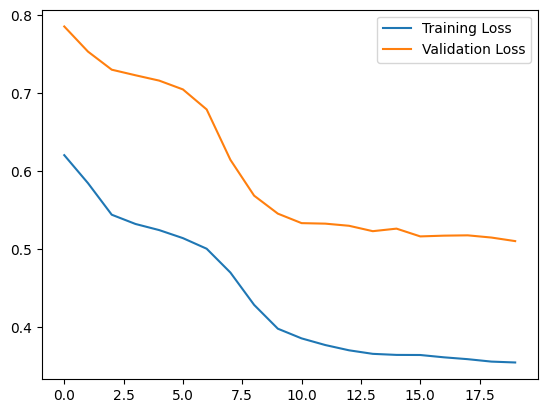

In [ ]:
anomalydetector.compile(optimizer='adam', loss='mae')
history = anomalydetector.fit(ux_train, ux_train,
          epochs=20,
          batch_size=16,
          validation_data=(ux_test, ux_test),
          shuffle=True)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [ ]:
df5 = df2[df2['uid']=="90006"]
df5=df5.reset_index(drop=True)
dfa = cropAndPadDfFront(df5,length = MLength, padding = ['linear','edge'], cols=['timestamp','sensordata'])
print(dfa['sensordata'].apply(lambda x: (x.shape)).unique())
print(dfa['timestamp'].apply(lambda x: (x.shape)).value_counts())
ax = dfa['sensordata']
ay = dfa['uid']
adata_array = np.array(ax.to_list())
adata_tensor = tf.convert_to_tensor(adata_array, dtype=tf.float32)

ax_train, ax_test, ay_train, ay_test = train_test_split(adata_tensor.numpy(),
                                                    ay,
                                                    test_size=0.33,
                                                    random_state=42)
amean = np.mean(ax_train, axis=0)
astd = np.std(ax_train, axis=0)
ax_train = (ax_train - amean) / ustd
ax_test = (ax_test - amean) / ustd


timestamp  :  linear
sensordata  :  edge
[(2000, 3)]
(2000,)    18
Name: timestamp, dtype: int64


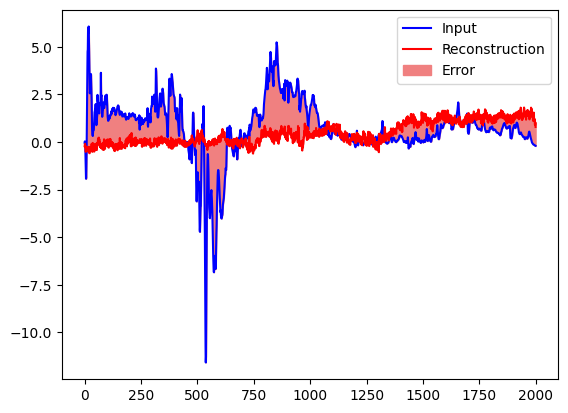

In [ ]:
encoded_data = anomalydetector.encoder(ax_test).numpy()
decoded_data = anomalydetector.decoder(encoded_data).numpy()

plt.plot(ax_test[0][:,0], 'b')
plt.plot(decoded_data[0][:,0], 'r')
plt.fill_between(np.arange(MLength), decoded_data[0][:,0], ax_test[0][:,0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Detect anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.


Plot the reconstruction error on normal ECGs from the training set

4/4 [==============================] - 0s 3ms/step


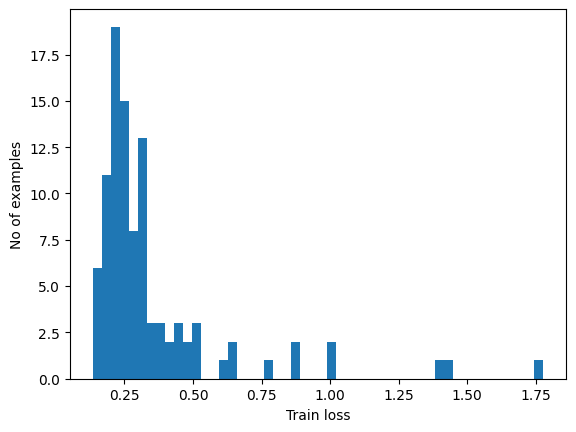

In [ ]:
reconstructions = anomalydetector.predict(ux_train)
train_loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions, ux_train), axis=1)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Choose a threshold value that is one standard deviations above the mean.

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.6263349


Note: There are other strategies you could use to select a threshold value above which test examples should be classified as anomalous, the correct approach will depend on your dataset. You can learn more with the links at the end of this tutorial.

If you examine the reconstruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the [precision](https://developers.google.com/machine-learning/glossary#precision) and [recall](https://developers.google.com/machine-learning/glossary#recall) of your classifier.

1/1 [==============================] - 0s 17ms/step


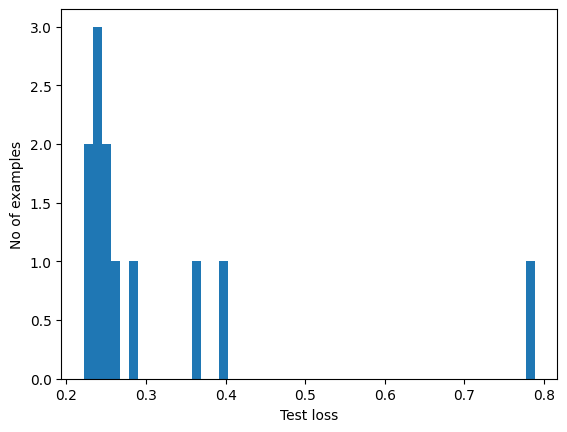

In [ ]:
reconstructions = anomalydetector.predict(ax_train)
test_loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions, ax_train), axis=1)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(anomalydetector, x_test, threshold)
print_stats(preds, y_test)

ValueError: ignored